In [3]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow as tf
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import copy
import torch.optim as optim

In [4]:
class_names = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}

classes = [class_name for class_name in class_names.values()]

In [5]:

models = ['resnet', 'inception_v3', 'alexnet', 'efficientnet_b7', 'vgg_19']
paths = [f'./models/{model_name}.pt' for model_name in models]
loaded_models = {}

for path, model_name in zip(paths, models):
    try:
        model = torch.jit.load(path)
        loaded_models[model_name] = model
    except Exception:
        print(f'model {model_name} is not available')

model resnet is not available
model inception_v3 is not available
model efficientnet_b7 is not available
model vgg_19 is not available


In [6]:
preprocess_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

In [7]:
df = pd.read_csv("./data/data.csv") # path to images
y = torch.as_tensor(df['label'].values)
image_paths = df['path']
images = []

for path in image_paths:
    try:
        img = Image.open(path)
        images.append(preprocess_image(img.convert('RGB')))
    except Exception as e:
        pass

X = torch.stack(images)
print(X.shape)

torch.Size([10303, 3, 224, 224])


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_batch(X, y, batch_size, iteration):
    start = batch_size * iteration
    end = (batch_size) * (iteration + 1)
    if end > X.shape[0]:
        end = X.shape[0]
    return X[start:end, :, :, :], y[start:end]

batch test : 0/52
batch test : 5/52
batch test : 10/52
batch test : 15/52
batch test : 20/52
batch test : 25/52
batch test : 30/52
batch test : 35/52
batch test : 40/52
batch test : 45/52
batch test : 50/52


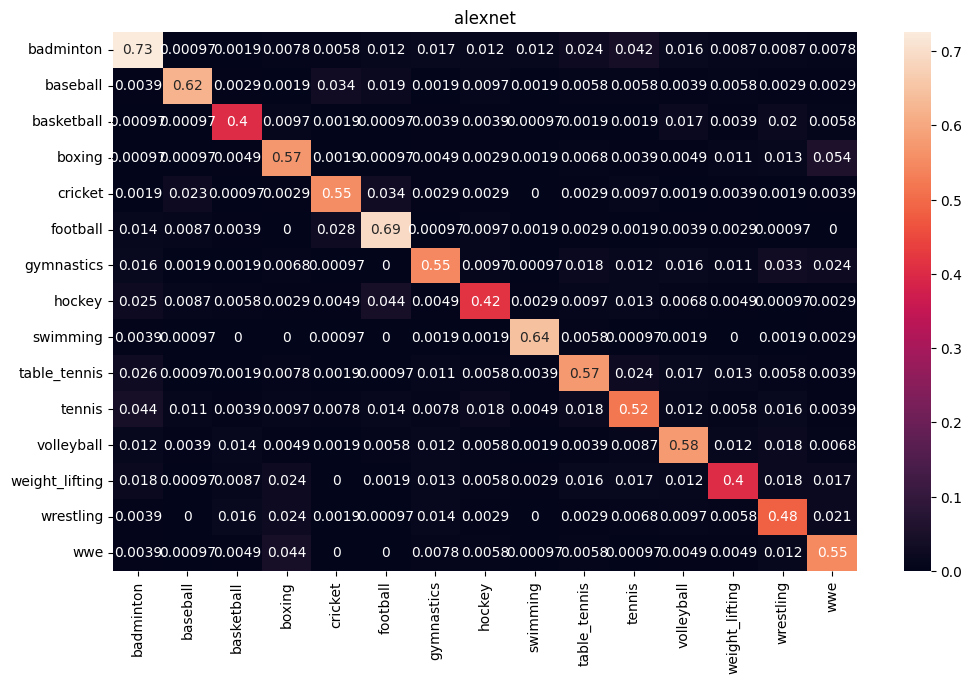

In [10]:
batch_size = 200

for model_name, model in loaded_models.items():
    model.eval()
    batch_test_count = (X.shape[0] // batch_size) + 1

    y_pred = []
    y_true = []

    for num_batch in range(batch_test_count):
        if (num_batch % 20 == 0):
            print(f'batch test : {num_batch}/{batch_test_count}')
        inputs, labels = get_batch(X, y, batch_size, num_batch)
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        labels = labels.numpy()
        y_true.extend(labels) # Save Truth
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix / cf_matrix.astype(float).sum(axis=1, keepdims=True), index = [i for i in classes],
                            columns = [i for i in classes])
        plt.figure(figsize = (20,15))
        sn.heatmap(df_cm, annot=True)
        plt.title(model_name, fontsize = 16)
        plt.show()